# Exploration and Cleanup
- Starting from "311_Pothole_History", we'll extract the data into a dataframe
- After cleaning and compiling, a list of zip codes will be pulled from the data to be run through the Census API
- While exploring the range of data, summary statistics will be calculated for the list of zip codes
- Finally we'll export the datasets to new csv files

## Loading the Data

In [1]:
# Dependencies and Imports
import pandas as pd
import requests
import json
import matplotlib as plt
import matplotlib.pyplot as plt
import gmaps
from census import Census
from us import states
import numpy as np
from config import census_API

# Census API Key
c = Census(census_API)

# Import and preview the dataset in a dataframe
path = './Resources/311_Pothole_History.csv'
df = pd.DataFrame(pd.read_csv(path))

# Preview the dataset
print(f"Total # of complaints in the dataset: {len(df)}")
df.head()

Total # of complaints in the dataset: 50073


,CASE ID,SOURCE,DEPARTMENT,WORK GROUP,REQUEST TYPE,CREATION MONTH,CREATION YEAR,STATUS,EXCEEDED EST TIMEFRAME,CLOSED DATE,...,CLOSED YEAR,DAYS TO CLOSE,STREET ADDRESS,ADDRESS WITH GEOCODE,ZIP CODE,NEIGHBORHOOD,COUNCIL DISTRICT,PARCEL ID NO,LATITUDE,LONGITUDE
0,2019169222,PHONE,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,9,2019,RESOL,Y,11/7/2019,...,2019.0,48.0,13110 E 57th St,"13110 E 57th St64133\n(39.018605, -94.426046)",64133.0,Blue Vue Hills,5.0,63787,39.018605,-94.426046
1,2019126105,PHONE,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,7,2019,RESOL,Y,10/24/2019,...,2019.0,113.0,1420 E 75th Ter,"1420 E 75th Ter64131\n(38.990601, -94.570141)",64131.0,East Meyer 6,5.0,115894,38.990601,-94.570141
2,2019126468,WEB,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,7,2019,RESOL,Y,10/24/2019,...,2019.0,113.0,5500 Michigan Ave,"5500 Michigan Ave64130\n(39.026622, -94.563667)",64130.0,Blue Hills,5.0,147750,39.026622,-94.563667
3,2019183619,PHONE,Public Works,Public Works-Street and Traffic-District 1,Streets / Roadways / Alleys-Pothole-District 1,10,2019,RESOL,Y,11/22/2019,...,2019.0,30.0,6344 NE Pleasant Valley Rd,"6344 NE Pleasant Valley Rd64119\n(39.216929, -...",64119.0,Shoal Creek,1.0,89139,39.216929,-94.504961
4,2019190590,PHONE,Public Works,Public Works-Street and Traffic-District 3,Streets / Roadways / Alleys-Pothole-District 3,11,2019,RESOL,Y,11/18/2019,...,2019.0,10.0,9500 Blue Ridge Blvd,"9500 Blue Ridge Blvd64134\n(38.952042, -94.508...",64134.0,Fairlane,5.0,56861,38.952042,-94.508463


## Early Data Exploration

In [2]:
# Investigating values for non-standard columns
print(f"Source values: {df['SOURCE'].unique()}")
print(f"Work group values: {df['WORK GROUP'].unique()}")
print(f"Request type values: {df['REQUEST TYPE'].unique()}")
print(f"Status values: {df['STATUS'].unique()}")

Source values: ['PHONE' 'WEB' 'EMAIL' 'BOT' 'TWIR' 'WALK' 'EDC' 'VOICE' 'FAX' 'INSPE'
 'SYS' 'MAIL' 'EIP' 'SPNSH']
Work group values: ['Public Works-Street and Traffic-District 3'
 'Public Works-Street and Traffic-District 1'
 'Public Works-Street and Traffic-District 2'
 'City Managers Office-311 Call Center-Support'
 'Public Works-Capital Projects-Sidewalks' 'Parks and Rec-South Region-'
 'Public Works-Capital Projects-Traffic Permits'
 'Parks and Rec-Central Region-' 'Parks and Rec-Administration-']
Request type values: ['Streets / Roadways / Alleys-Pothole-District 3'
 'Streets / Roadways / Alleys-Pothole-District 1'
 'Streets / Roadways / Alleys-Pothole-District 2'
 'Streets / Roadways / Alleys-Pothole-Bridge' 'Pothole (North of River)'
 'Pothole (South of 47th Street and West Of Blue PKWY)'
 'Pothole (South of 47th Street)'
 'Pothole (South of River to 47th Street)'
 'Pothole (River south to 47th Street)'
 'Pothole (River south to 47th Street and East of Blue PKWY)'
 'Streets / R

In [3]:
# Identifying data ranges
print(f"Dataset covers {df['CREATION YEAR'].nunique()} years, {df['ZIP CODE'].nunique()} zipcodes, and {df['NEIGHBORHOOD'].nunique()} neighborhoods")

Dataset covers 14 years, 55 zipcodes, and 249 neighborhoods


## Cleaning the Data

In [4]:
# Begin cleaning data. We'll start by only using resolved complaints (open/canceled complaints lack some of the data we'd need if we want to use closing dates)
resolved_df = df.loc[(df['STATUS']=='RESOL')]
print(f"Current number of rows: {len(resolved_df)}")

# Cut down the number of columns to main identifying data. We'll primarily be using zip codes to pull census data
# Extra location data and "closed" data has been removed for ease.
reduced_resolved_df = resolved_df[['CASE ID', 'SOURCE', 'CREATION MONTH', 
                                   'CREATION YEAR', 'STATUS', 'EXCEEDED EST TIMEFRAME', 
                                   'DAYS TO CLOSE', 'ZIP CODE', 'NEIGHBORHOOD']]

# Drop any rows that still have missing data
clean_df = reduced_resolved_df.dropna(how='any').copy()
clean_df.reset_index(drop=True, inplace=True)
print(f"Clean number of rows: {len(clean_df)}")

# Format columns to drop decimal places
clean_df['ZIP CODE'] = clean_df['ZIP CODE'].astype(int)
clean_df['DAYS TO CLOSE'] = clean_df['DAYS TO CLOSE'].astype(int)

# Output the dataframe to a csv and preview the final cleaned dataframe
clean_df.to_csv('./Resources/PotholeData.csv', index=False)
clean_df

Current number of rows: 49499
Clean number of rows: 48070


,CASE ID,SOURCE,CREATION MONTH,CREATION YEAR,STATUS,EXCEEDED EST TIMEFRAME,DAYS TO CLOSE,ZIP CODE,NEIGHBORHOOD
0,2019169222,PHONE,9,2019,RESOL,Y,48,64133,Blue Vue Hills
1,2019126105,PHONE,7,2019,RESOL,Y,113,64131,East Meyer 6
2,2019126468,WEB,7,2019,RESOL,Y,113,64130,Blue Hills
3,2019183619,PHONE,10,2019,RESOL,Y,30,64119,Shoal Creek
4,2019190590,PHONE,11,2019,RESOL,Y,10,64134,Fairlane
...,...,...,...,...,...,...,...,...,...
48065,2019170484,PHONE,9,2019,RESOL,N,1,64126,East Blue Valley
48066,2019170942,PHONE,9,2019,RESOL,Y,52,64110,Western 49-63
48067,2019171791,PHONE,9,2019,RESOL,Y,50,64134,Hickman Mills South
48068,2019170397,TWIR,9,2019,RESOL,N,2,64108,Wendell Phillips


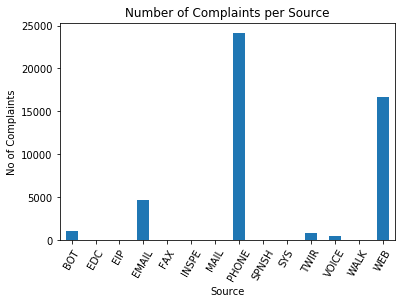

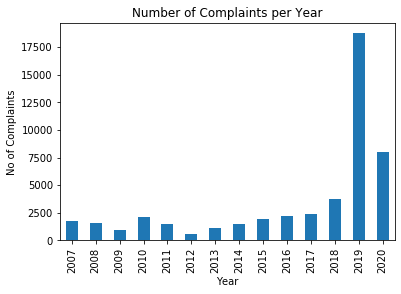

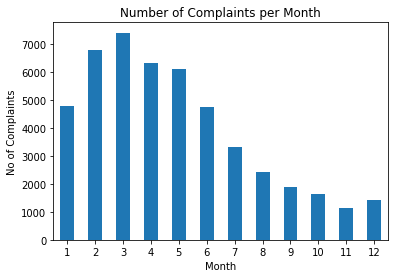

In [5]:
# Find potential variables for analysis
complaints_by_source = clean_df["SOURCE"].value_counts().sort_index(ascending=True)
complaints_by_source.plot.bar()
plt.xlabel('Source')
plt.ylabel('No of Complaints')
plt.title('Number of Complaints per Source')
plt.xticks(rotation=60)
plt.savefig('./Images/no_complaints_per_source.png')
plt.show()

complaints_by_year = clean_df["CREATION YEAR"].value_counts().sort_index()
complaints_by_year.plot.bar()
plt.xlabel('Year')
plt.ylabel('No of Complaints')
plt.title('Number of Complaints per Year')
plt.xticks(rotation=90)
plt.savefig('./Images/no_complaints_per_year.png')
plt.show()

complaints_by_month = clean_df["CREATION MONTH"].value_counts().sort_index()
complaints_by_month.plot.bar()
plt.xlabel('Month')
plt.ylabel('No of Complaints')
plt.title('Number of Complaints per Month')
plt.xticks(rotation=0)
plt.savefig('./Images/no_complaints_per_month.png')
plt.show()

## Pulling and Aggregating Data
Using the dataframe to pull out our list of zipcodes, we'll process a range of statistics for each zip code to arrange in a new dataframe. We can combine this later with our Census data for a single dataframe.

In [6]:
# Assembling a clean list of the zip codes in the data set
zip_codes = df['ZIP CODE'].dropna().unique()
zip_codes = zip_codes.astype(int)
zip_codes

array([64133, 64131, 64130, 64119, 64134, 64108, 64113, 64132, 64112,
       64146, 64127, 64125, 64149, 64138, 64114, 64145, 64105, 64123,
       64110, 64137, 64155, 64109, 64154, 64151, 64124, 64116, 64120,
       64139, 64152, 64129, 64158, 64106, 64111, 64128, 64118, 64117,
       64136, 64126, 64157, 64156, 64101, 64163, 64153, 64161, 64147,
       64167, 64102, 64166, 64165, 64164, 64160, 64068, 64012, 64052,
       64030])

In [7]:
# Using groupby, calculate statistics for each zip code in the data set
zipcode = clean_df.groupby(["ZIP CODE"])
complaints = zipcode["CASE ID"].count()
percent_complaints = complaints / clean_df["CASE ID"].count() * 100
avg_close = zipcode["DAYS TO CLOSE"].mean()

# Find the most utilized complaint source for each zip code
max_source_list = []
for code in zip_codes:
    try:
        zip_group = zipcode.get_group(code)
        max_source = zip_group["SOURCE"].value_counts().nlargest(1).index.tolist()[0]
        max_source_list.append(max_source)
    except:
        pass

In [8]:
# Load the stats into a dataframe
zipcode_stats = {"No. of Complaints": complaints,
                    "% of Complaints": percent_complaints,
                    "Most Utilized Source": max_source_list, 
                    "Avg. Days to Close": avg_close}
zipcode_stats_df = pd.DataFrame(zipcode_stats)

# Format the data in the dataframe and preview
zipcode_stats_df["Avg. Days to Close"] = round(zipcode_stats_df["Avg. Days to Close"], 2)
zipcode_stats_df["% of Complaints"] = round(zipcode_stats_df["% of Complaints"], 2)
zipcode_stats_df.to_csv('./Resources/ZipCodeData.csv', index=False)
zipcode_stats_df.tail()

,No. of Complaints,% of Complaints,Most Utilized Source,Avg. Days to Close
ZIP CODE,,,,
64163,98,0.20,PHONE,27.73
64164,48,0.10,PHONE,23.58
64165,16,0.03,PHONE,18.44
64166,54,0.11,PHONE,26.35
64167,7,0.01,PHONE,26.57


## Census API Data Pull

In [9]:
# Generate an empty list to fill with the census data
data = []

# Iterate through the list of zip codes to pull the census data
for ea in zip_codes:
    census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E","B19301_001E","B17001_002E","C02003_003E","B01002A_002E","B01002A_003E","B01001A_023E","B01001A_024E","B01001A_025E","B01001A_026E","B01001A_027E"), {'for': 'zip code tabulation area:'+str(ea)})
    try:
        data.append(census_data[0])
    except:
        next

In [10]:
# Store the data into a dataframe
data_df = pd.DataFrame(data)
data_df.head()

,NAME,B19013_001E,B01003_001E,B01002_001E,B19301_001E,B17001_002E,C02003_003E,B01002A_002E,B01002A_003E,B01001A_023E,B01001A_024E,B01001A_025E,B01001A_026E,B01001A_027E,zip code tabulation area
0,ZCTA5 64133,50681.0,35163.0,40.8,26720.0,4690.0,20850.0,44.1,49.4,539.0,630.0,627.0,1280.0,1598.0,64133
1,ZCTA5 64131,45688.0,22932.0,37.2,30411.0,4021.0,11811.0,38.9,43.2,428.0,461.0,777.0,573.0,748.0,64131
2,ZCTA5 64130,31166.0,19996.0,39.3,21925.0,5238.0,1474.0,29.6,29.5,79.0,139.0,46.0,153.0,35.0,64130
3,ZCTA5 64119,68841.0,27848.0,38.3,33224.0,1785.0,23323.0,39.7,43.2,712.0,982.0,959.0,1433.0,1713.0,64119
4,ZCTA5 64134,41543.0,23874.0,31.3,20078.0,5507.0,6793.0,47.1,45.5,147.0,283.0,308.0,386.0,384.0,64134


## Reformatting and Cleaning
Start by renaming and reordering all the columns. Typecast columns as necessary and format the output for percentages and monetary values. Remove any problematic data (negative values).

In [11]:
# Renaming the columns of the dataframe
data_df = data_df.rename(
    columns={
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income ($)",
        "B19301_001E": "Per Capita Income ($)",
        "B17001_002E": "Poverty Count",
        "C02003_003E": "White Population (%)",
        "B01002A_002E": "Male Median Age",
        "B01002A_003E": "Female Median Age",
        "B01001A_023E": "Fem. 20-24 (%)",
        "B01001A_024E": "Fem. 25-29 (%)",
        "B01001A_025E": "Fem. 30-34 (%)",
        "B01001A_026E": "Fem. 35-44 (%)",
        "B01001A_027E": "Fem. 45-54 (%)",
        "NAME": "Name",
        "zip code tabulation area": "Zip Code"
    }
)

# Reordering the columns, dropping the "Name" column
data_df = data_df[[
    'Zip Code',
    'Population',
    'White Population (%)',
    'Poverty Count',
    'Household Income ($)',
    'Per Capita Income ($)',
    'Median Age',
    'Male Median Age',
    'Female Median Age',
    'Fem. 20-24 (%)',
    'Fem. 25-29 (%)',
    'Fem. 30-34 (%)',
    'Fem. 35-44 (%)',
    'Fem. 45-54 (%)'
]]

# Calculate the specific population counts as percentages 
pop_list = ["White Population (%)", "Fem. 20-24 (%)", "Fem. 25-29 (%)", "Fem. 30-34 (%)", "Fem. 35-44 (%)", "Fem. 45-54 (%)"]

for column in pop_list:
    data_df[column] = data_df[column] / data_df["Population"] * 100
    
data_df[pop_list] = round(data_df[pop_list], 2)

# Type non-percent data for calculations and preview the dataframe
non_percent_col = ["Zip Code", "Population", "Poverty Count", "Household Income ($)", "Per Capita Income ($)"]
data_df[non_percent_col] = data_df[non_percent_col].astype(int)
data_df.head()

,Zip Code,Population,White Population (%),Poverty Count,Household Income ($),Per Capita Income ($),Median Age,Male Median Age,Female Median Age,Fem. 20-24 (%),Fem. 25-29 (%),Fem. 30-34 (%),Fem. 35-44 (%),Fem. 45-54 (%)
0,64133,35163,59.30,4690,50681,26720,40.8,44.1,49.4,1.53,1.79,1.78,3.64,4.54
1,64131,22932,51.50,4021,45688,30411,37.2,38.9,43.2,1.87,2.01,3.39,2.50,3.26
2,64130,19996,7.37,5238,31166,21925,39.3,29.6,29.5,0.40,0.70,0.23,0.77,0.18
3,64119,27848,83.75,1785,68841,33224,38.3,39.7,43.2,2.56,3.53,3.44,5.15,6.15
4,64134,23874,28.45,5507,41543,20078,31.3,47.1,45.5,0.62,1.19,1.29,1.62,1.61


In [12]:
# Removing oddball data from the dataset (zero population and negative incomes)
print(f"Current number of rows: {len(data_df)}")
data_df = data_df.loc[(data_df['Population'] > 0) & (data_df['Household Income ($)'] > 0)]
data_df.reset_index(drop=True, inplace=True)
print(f"New number of rows: {len(data_df)}")
data_df.to_csv('./Resources/CensusData.csv', index=False)
data_df.head()

Current number of rows: 54
New number of rows: 51


,Zip Code,Population,White Population (%),Poverty Count,Household Income ($),Per Capita Income ($),Median Age,Male Median Age,Female Median Age,Fem. 20-24 (%),Fem. 25-29 (%),Fem. 30-34 (%),Fem. 35-44 (%),Fem. 45-54 (%)
0,64133,35163,59.30,4690,50681,26720,40.8,44.1,49.4,1.53,1.79,1.78,3.64,4.54
1,64131,22932,51.50,4021,45688,30411,37.2,38.9,43.2,1.87,2.01,3.39,2.50,3.26
2,64130,19996,7.37,5238,31166,21925,39.3,29.6,29.5,0.40,0.70,0.23,0.77,0.18
3,64119,27848,83.75,1785,68841,33224,38.3,39.7,43.2,2.56,3.53,3.44,5.15,6.15
4,64134,23874,28.45,5507,41543,20078,31.3,47.1,45.5,0.62,1.19,1.29,1.62,1.61


## Merging and Exporting

In [13]:
# Merge the zipcode statistics with the census data into a single dataframe
full_data = pd.merge(data_df, zipcode_stats_df, left_on=["Zip Code"], right_index=True)
full_data.head()

,Zip Code,Population,White Population (%),Poverty Count,Household Income ($),Per Capita Income ($),Median Age,Male Median Age,Female Median Age,Fem. 20-24 (%),Fem. 25-29 (%),Fem. 30-34 (%),Fem. 35-44 (%),Fem. 45-54 (%),No. of Complaints,% of Complaints,Most Utilized Source,Avg. Days to Close
0,64133,35163,59.30,4690,50681,26720,40.8,44.1,49.4,1.53,1.79,1.78,3.64,4.54,1767,3.68,PHONE,26.83
1,64131,22932,51.50,4021,45688,30411,37.2,38.9,43.2,1.87,2.01,3.39,2.50,3.26,4134,8.60,WEB,25.71
2,64130,19996,7.37,5238,31166,21925,39.3,29.6,29.5,0.40,0.70,0.23,0.77,0.18,2163,4.50,PHONE,23.80
3,64119,27848,83.75,1785,68841,33224,38.3,39.7,43.2,2.56,3.53,3.44,5.15,6.15,1177,2.45,PHONE,26.79
4,64134,23874,28.45,5507,41543,20078,31.3,47.1,45.5,0.62,1.19,1.29,1.62,1.61,2533,5.27,WEB,20.01


In [14]:
# Export the merged dataframe to a CSV
full_data.to_csv('./Resources/FullDataSet.csv', index=False)